# Assumptions:

In [1]:
# set probabilities:
BELOW_RATE_OF_RETURN_g1 = -0.4661
BELOW_RATE_OF_RETURN_g2 = -0.4661
BELOW_RATE_OF_RETURN_g3 = -0.3634
BELOW_RATE_OF_RETURN_g4 = -0.3634
BELOW_RATE_OF_RETURN_g5 = -0.3634
BELOW_RATE_OF_RETURN_g6 = -0.3211

#treat these as NEG_OPER_PROFIT_gX
FOURTY_PERCENT_g1 = -0.8010
FOURTY_PERCENT_g2 = -0.8010
FOURTY_PERCENT_g3 = -0.7755
FOURTY_PERCENT_g4 = -0.7755
FOURTY_PERCENT_g5 = -0.7755
FOURTY_PERCENT_g6 = -0.7469

#rerun model 20 times, incrementing neg_oper_profit by -5% each time
NEG_OPER_PROFIT = -0.85


# set the number of samples you want to generate
NUM_SAMPLES = 10000


# Start model

In [2]:
import numpy as np
# from scipy.linalg import eigh, cholesky
# from scipy.stats import norm
# from scipy.spatial import distance
import seaborn as sns 

import pandas as pd
import matplotlib.pyplot as plt

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# ---- First, we want to generate simulations from the 6 underlying RV, $ x_i $,  for i = 1,...,6, where $x_i$ are NORMALLY DISTRIBUTED with known mean and variance and are correlated with each other ----

In [3]:
# read in covariance matrix as a dataframe
df_cov = pd.read_excel("Variance Matrices.xlsx", sheet_name = "cov", index_col = 0)
df_cov

# convert cov dataframe to an array 
cov_array = np.array(df_cov)
cov_array

,Industrial feedstock: Ammonia,Industrial feedstock: Refining & other,Industrial heat,Power,Transport: HGV road & rail,Transport: Marine
Industrial feedstock: Ammonia,0.054319,0.014208,-0.014652,0.004455,-0.012164,-0.008068
Industrial feedstock: Refining & other,0.014208,0.041056,-0.004413,0.005135,-0.010829,-0.006443
Industrial heat,-0.014652,-0.004413,0.045463,0.015136,0.038358,0.011271
Power,0.004455,0.005135,0.015136,0.027171,0.009948,0.003242
Transport: HGV road & rail,-0.012164,-0.010829,0.038358,0.009948,0.030230,0.008189
Transport: Marine,-0.008068,-0.006443,0.011271,0.003242,0.008189,0.021163


array([[ 0.05431874,  0.01420841, -0.01465216,  0.00445543, -0.01216418,
        -0.0080684 ],
       [ 0.01420841,  0.04105613, -0.00441315,  0.0051354 , -0.01082936,
        -0.0064431 ],
       [-0.01465216, -0.00441315,  0.04546345,  0.01513586,  0.03835776,
         0.01127145],
       [ 0.00445543,  0.0051354 ,  0.01513586,  0.02717133,  0.00994801,
         0.00324229],
       [-0.01216418, -0.01082936,  0.03835776,  0.00994801,  0.03023001,
         0.00818946],
       [-0.0080684 , -0.0064431 ,  0.01127145,  0.00324229,  0.00818946,
         0.02116256]])

In [4]:
# generate random samples using mean = 0 and cov matrix
simulations = np.random.multivariate_normal(mean=np.zeros(6), cov=cov_array, size=NUM_SAMPLES)

df_simulations = pd.DataFrame(simulations)
df_simulations.rename(columns = {0:'x1',1:'x2',2:'x3',3:'x4',4:'x5',5:'x6'}, inplace=True)
df_simulations

<ipython-input-4-e3ebb5cbf039>:2: RuntimeWarning: covariance is not positive-semidefinite.
  simulations = np.random.multivariate_normal(mean=np.zeros(6), cov=cov_array, size=NUM_SAMPLES)


,x1,x2,x3,x4,x5,x6
0,0.369001,0.166816,0.117329,0.122954,0.030373,-0.049348
1,-0.432259,-0.050726,0.114307,-0.044920,0.135253,-0.118010
2,0.166565,0.138417,0.171066,0.219982,0.038857,0.101793
3,0.324958,0.202978,-0.183704,-0.006686,-0.233050,0.055588
4,-0.410322,-0.407276,-0.048122,-0.326714,0.149544,0.262961
...,...,...,...,...,...,...
9995,0.270803,0.424424,0.070244,0.298211,0.026736,-0.002715
9996,0.126286,0.054029,-0.429209,-0.048662,-0.318987,-0.120491
9997,-0.164307,0.047720,-0.043943,-0.023848,-0.114536,0.002336
9998,0.179217,0.159745,0.115760,0.056960,0.009299,-0.066739


#### We have generated simulations of our 6 underlying RVs.
#### Let's sanity check that the simulated observations make sense compared to the actual observations

In [5]:
### sanity check: compute cov matrix from simulation. ###

# Measure the euclidean distance between simulated cov matrix and empirical cov matrix
# https://medium.com/swlh/euclidean-distance-matrix-4c3e1378d87f

# if Euclidean distance is sufficiently far from 0, then your simulations messed up somewhere

def EDM(A,B):
    p1 = np.sum(A**2, axis=1)[:, np.newaxis]
    p2 = np.sum(B**2, axis=1)
    p3 = -2 * np.dot(A,B.T)
    return np.round(np.sqrt(p1+p2+p3),2)

# create covariance array from simulations
simulations_cov_array = np.array(df_simulations.cov())

# calculate euclidean distance
EDM(simulations_cov_array,cov_array) # distance seems sufficiently close to 0

array([[0.  , 0.05, 0.11, 0.07, 0.1 , 0.08],
       [0.05, 0.  , 0.09, 0.05, 0.08, 0.06],
       [0.11, 0.09, 0.  , 0.05, 0.01, 0.05],
       [0.07, 0.05, 0.05, 0.  , 0.04, 0.04],
       [0.1 , 0.08, 0.01, 0.04, 0.  , 0.04],
       [0.08, 0.06, 0.05, 0.03, 0.04, 0.  ]])

In [6]:
# can manually check if cov matrix of simulations looks like cov matrix of data
df_simulations.cov()

,x1,x2,x3,x4,x5,x6
x1,0.056176,0.014138,-0.015118,0.004816,-0.012406,-0.008715
x2,0.014138,0.039738,-0.004139,0.005655,-0.009510,-0.005920
x3,-0.015118,-0.004139,0.047550,0.014964,0.036217,0.011381
x4,0.004816,0.005655,0.014964,0.027278,0.009901,0.003275
x5,-0.012406,-0.009510,0.036217,0.009901,0.032408,0.008498
x6,-0.008715,-0.005920,0.011381,0.003275,0.008498,0.021597


Text(0.5, 0.98, 'Plotting some x_i correlations')

Text(0.5, 1.0, 'x1 and x2 scatter')

Text(0.5, 1.0, 'x1 and x3 scatter')

Text(0.5, 1.0, 'x1 and x4 scatter')

Text(0.5, 1.0, 'x3 and x5 scatter')

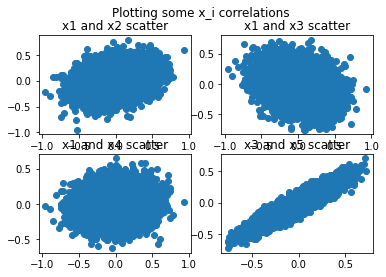

In [7]:
# some more sanity checks - let's plot some variables
fig, axs = plt.subplots(2,2)
fig.suptitle('Plotting some x_i correlations')

#x1 and x2 are indeed positively correlated
axs[0,0].scatter(df_simulations['x1'], df_simulations['x2'])
axs[0,0].set_title('x1 and x2 scatter')

# x1 and x3 are indeed negatively correlated
axs[0,1].scatter(df_simulations['x1'], df_simulations['x3'])
axs[0,1].set_title('x1 and x3 scatter')

# x1 and x4 are indeed weakly correlated
axs[1,0].scatter(df_simulations['x1'], df_simulations['x4'])
axs[1,0].set_title('x1 and x4 scatter')

# x3 and x5 are indeed strongly correlated
axs[1,1].scatter(df_simulations['x3'], df_simulations['x5'])
axs[1,1].set_title('x3 and x5 scatter')

## So we have created our simulations of $ x_i $ for i from 1 to 6. 
## Now we can generate subarchetype simulations: $ g_j(X) $ = weighted sum of $ x_i $, for j subarchetypes (j = 1,...,6)

In [8]:
# import weights 
# read in weights matrix as a dataframe
df_weights = pd.read_excel("Variance Matrices.xlsx", sheet_name = "weights_subarchetype", index_col = 0)

#replace NA with 0:
df_weights.fillna(0, inplace=True)
df_weights

,subarchetype1,subarchetype2,subarchetype3,subarchetype4,subarchetype5,subarchetype6
Industrial feedstock: Ammonia,0.0,0.00,0.8,0.25,0.15,0.0
Industrial feedstock: Refining & other,0.0,0.00,0.0,0.25,0.15,0.0
Industrial heat,0.0,0.25,0.1,0.25,0.15,0.1
Power,0.0,0.25,0.1,0.25,0.15,0.3
Transport: HGV road & rail,0.8,0.40,0.0,0.00,0.30,0.4
Transport: Marine,0.2,0.10,0.0,0.00,0.10,0.2


### 1) Simulate the first subarchetype: "Medium grid-sourced electrolytic producer: Transport-focused"

In [9]:
# simulate g(X) for "Medium grid-sourced electrolytic producer: Transport-focused"

g_subarchetype1_simulations = (
 df_weights["subarchetype1"][0]*df_simulations['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype1"][1]*df_simulations['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype1"][2]*df_simulations['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype1"][3]*df_simulations['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype1"][4]*df_simulations['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype1"][5]*df_simulations['x6'] #weight of x6 * observations of x6
)

g_subarchetype1_simulations

0       0.014429
1       0.084601
2       0.051444
3      -0.175323
4       0.172228
          ...   
9995    0.020846
9996   -0.279288
9997   -0.091162
9998   -0.005909
9999   -0.161630
Length: 10000, dtype: float64

<AxesSubplot:>

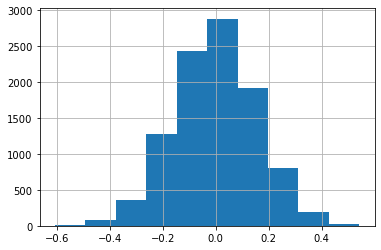

In [10]:
g_subarchetype1_simulations.hist()

#### Compute the left-sided probability of g distribution, for subarchetype 1

<AxesSubplot:ylabel='Probability'>

Text(0.5, 1.0, 'Subarchetype 1 Simulated Distribution - Normal x_i assumption')

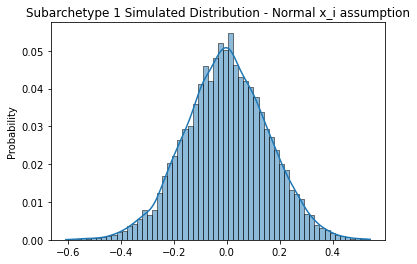

In [11]:
# let's create the empirical distribution of g archetype 1 
sns.histplot(data=g_subarchetype1_simulations, kde=True, stat='probability')
plt.title("Subarchetype 1 Simulated Distribution - Normal x_i assumption")


plt.savefig('g_subarchetype1_distribution-NORMAL_UNDERLYING.png')

<AxesSubplot:ylabel='Probability'>

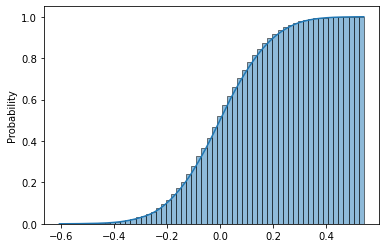

In [12]:
# left sided area of PDF is equal to the cumulative probability 
# convert to CDF to extract the probability at any given demand value

sns.histplot(data=g_subarchetype1_simulations, kde=True, stat='probability', cumulative = True)

,Left-Sided Demand Deviation,Probability
0,-0.607589,0.000000
1,-0.601813,0.000017
2,-0.596037,0.000037
3,-0.590261,0.000062
4,-0.584484,0.000092
...,...,...
195,0.518744,0.999606
196,0.524520,0.999669
197,0.530296,0.999725
198,0.536072,0.999773


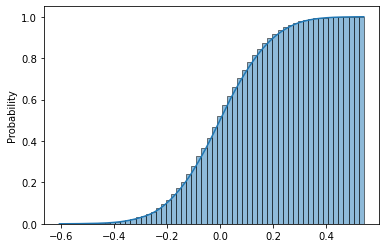

In [13]:
# get data from CDF
df_g_subarchetype1_probabilities = pd.DataFrame(
    np.transpose(
        sns.histplot(data=g_subarchetype1_simulations, kde=True, stat='probability', cumulative = True)
             .get_lines()[0].get_data()
            )
)

df_g_subarchetype1_probabilities.rename(columns={0:'Left-Sided Demand Deviation',1:'Probability'}, inplace=True)
df_g_subarchetype1_probabilities

In [14]:
# create function to find the closest value to any specified probability

def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

In [15]:
# create dataframe to store results
df_subarchetype_results = pd.DataFrame(
    {
        "Subarchetype":[
                        "1: Medium grid-sourced electrolytic producer: Transport-focused"
                        ,"2: Medium grid-sourced electrolytic producer: Variety of end-uses"
                        ,"3: CCUS-enabled producer serving a large industrial cluster: Primary off-taker"
                        ,"4: CCUS-enabled producer serving a large industrial cluster: Industry-specific mix"
                        ,"5: CCUS-enabled producer serving a large industrial cluster: Many off-takers"
                        ,"6: Small co-developed renewable electrolytic sites for assorted uses"
                        ],
        "Below Rate of Return":np.nan,
        "Negative Operating Profit":np.nan,
        "40%":np.nan
    }
)

df_subarchetype_results

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,NaN,NaN,NaN
1,2: Medium grid-sourced electrolytic producer: ...,NaN,NaN,NaN
2,3: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


In [16]:
# store results for subarchetype 1

df_subarchetype_results.at[0,'Below Rate of Return']=df_g_subarchetype1_probabilities.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g1,df_g_subarchetype1_probabilities,'Left-Sided Demand Deviation')[1]
][1]

try: 
    df_subarchetype_results.at[0,'Negative Operating Profit']=df_g_subarchetype1_probabilities.loc[
        find_neighbours(
            NEG_OPER_PROFIT,df_g_subarchetype1_probabilities,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_results.at[0,'Negative Operating Profit']=0
    
try:    
    df_subarchetype_results.at[0,'40%']=df_g_subarchetype1_probabilities.loc[
        find_neighbours(
            FOURTY_PERCENT_g1,df_g_subarchetype1_probabilities,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_results.at[0,'40%']=0
    

    
df_subarchetype_results

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.002402,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,NaN,NaN,NaN
2,3: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 2) Simulate the second subarchetype: "Medium grid-sourced electrolytic producer: Variety of end-uses"

In [17]:
# simulate g(X) for "Medium grid-sourced electrolytic producer: Variety of end-uses"
g_subarchetype2_simulations = (
 df_weights["subarchetype2"][0]*df_simulations['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype2"][1]*df_simulations['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype2"][2]*df_simulations['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype2"][3]*df_simulations['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype2"][4]*df_simulations['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype2"][5]*df_simulations['x6'] #weight of x6 * observations of x6
)

g_subarchetype2_simulations

0       0.067285
1       0.059647
2       0.123484
3      -0.135259
4      -0.007595
          ...   
9995    0.102537
9996   -0.259112
9997   -0.062529
9998    0.040225
9999   -0.101042
Length: 10000, dtype: float64

<AxesSubplot:>

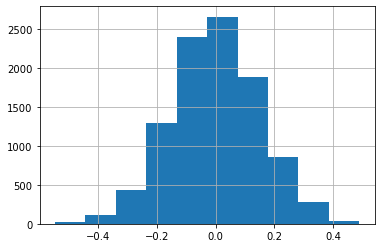

In [18]:
g_subarchetype2_simulations.hist()

#### Compute the left-sided probability of g distribution, for subarchetype 2

<AxesSubplot:ylabel='Probability'>

Text(0.5, 1.0, 'Subarchetype 2 Simulated Distribution - Normal x_i assumption')

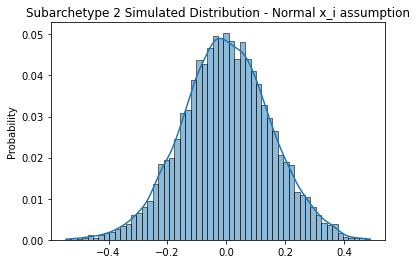

In [19]:
# let's create the empirical distribution of g archetype 2
sns.histplot(data=g_subarchetype2_simulations, kde=True, stat='probability')
plt.title("Subarchetype 2 Simulated Distribution - Normal x_i assumption")


plt.savefig('g_subarchetype2_distribution-NORMAL_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.545211,0.000000
1,-0.540018,0.000041
2,-0.534825,0.000091
3,-0.529633,0.000150
4,-0.524440,0.000217
...,...,...
195,0.467382,0.999449
196,0.472575,0.999531
197,0.477768,0.999602
198,0.482960,0.999663


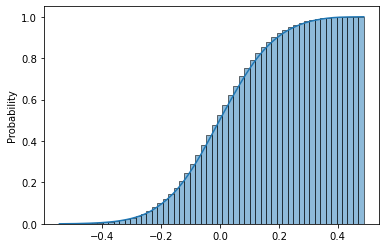

In [20]:
# get data from CDF
df_g_subarchetype2_probabilities = pd.DataFrame(
    np.transpose(
        sns.histplot(data=g_subarchetype2_simulations, kde=True, stat='probability', cumulative = True)
             .get_lines()[0].get_data()
            )
)

df_g_subarchetype2_probabilities.rename(columns={0:'Left-Sided Demand Deviation',1:'Probability'}, inplace=True)
df_g_subarchetype2_probabilities

In [21]:
# store results for subarchetype 2

df_subarchetype_results.at[1,'Below Rate of Return']=df_g_subarchetype2_probabilities.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g2,df_g_subarchetype2_probabilities,'Left-Sided Demand Deviation')[1]
][1]

try:
    df_subarchetype_results.at[1,'Negative Operating Profit']=df_g_subarchetype2_probabilities.loc[
        find_neighbours(
            NEG_OPER_PROFIT,df_g_subarchetype2_probabilities,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_results.at[1,'Negative Operating Profit']=0    
    
    
try:
    df_subarchetype_results.at[1,'40%']=df_g_subarchetype2_probabilities.loc[
        find_neighbours(
            FOURTY_PERCENT_g2,df_g_subarchetype2_probabilities,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_results.at[1,'40%']=0       


df_subarchetype_results

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.002402,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,0.001834,0.0,0.0
2,3: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 3) Simulate the third subarchetype: "CCUS-enabled producer serving a large industrial cluster: Primary off-taker"

0       0.319229
1      -0.338869
2       0.172357
3       0.240927
4      -0.365741
          ...   
9995    0.253488
9996    0.053242
9997   -0.138225
9998    0.160645
9999    0.081269
Length: 10000, dtype: float64

<AxesSubplot:>

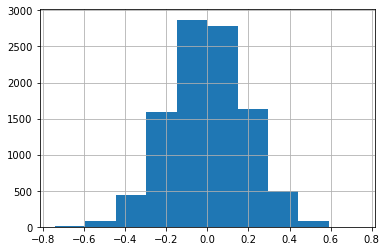

In [22]:
# simulate g(X) for "CCUS-enabled producer serving a large industrial cluster: Primary off-taker"
g_subarchetype3_simulations = (
 df_weights["subarchetype3"][0]*df_simulations['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype3"][1]*df_simulations['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype3"][2]*df_simulations['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype3"][3]*df_simulations['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype3"][4]*df_simulations['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype3"][5]*df_simulations['x6'] #weight of x6 * observations of x6
)

g_subarchetype3_simulations

g_subarchetype3_simulations.hist()

#### Compute the left-sided probability of g distribution, for subarchetype 3

<AxesSubplot:ylabel='Probability'>

Text(0.5, 1.0, 'Subarchetype 3 Simulated Distribution - Normal x_i assumption')

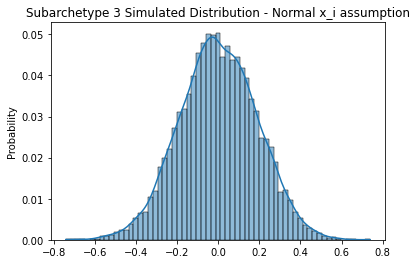

In [23]:
# let's create the empirical distribution of g archetype 3
sns.histplot(data=g_subarchetype3_simulations, kde=True, stat='probability')
plt.title("Subarchetype 3 Simulated Distribution - Normal x_i assumption")


plt.savefig('g_subarchetype3_distribution-NORMAL_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.741462,0.000000
1,-0.734021,0.000018
2,-0.726580,0.000037
3,-0.719140,0.000057
4,-0.711699,0.000078
...,...,...
195,0.709509,0.999845
196,0.716950,0.999853
197,0.724391,0.999863
198,0.731832,0.999872


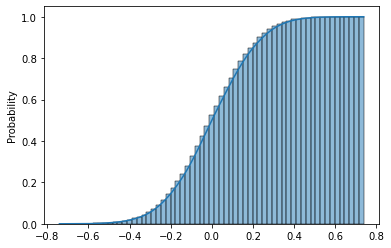

In [24]:
# get data from CDF
df_g_subarchetype3_probabilities = pd.DataFrame(
    np.transpose(
        sns.histplot(data=g_subarchetype3_simulations, kde=True, stat='probability', cumulative = True)
             .get_lines()[0].get_data()
            )
)

df_g_subarchetype3_probabilities.rename(columns={0:'Left-Sided Demand Deviation',1:'Probability'}, inplace=True)
df_g_subarchetype3_probabilities

In [25]:
# store results for subarchetype 3

df_subarchetype_results.at[2,'Below Rate of Return']=df_g_subarchetype3_probabilities.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g3,df_g_subarchetype3_probabilities,'Left-Sided Demand Deviation')[1]
][1]

try:
    df_subarchetype_results.at[2,'Negative Operating Profit']=df_g_subarchetype3_probabilities.loc[
        find_neighbours(
            NEG_OPER_PROFIT,df_g_subarchetype3_probabilities,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_results.at[2,'Negative Operating Profit']=0     

    
try:
    df_subarchetype_results.at[2,'40%']=df_g_subarchetype3_probabilities.loc[
        find_neighbours(
            FOURTY_PERCENT_g3,df_g_subarchetype3_probabilities,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_results.at[2,'40%']=0      
    
    

df_subarchetype_results

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.002402,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,0.001834,0.0,0.0
2,3: CCUS-enabled producer serving a large indus...,0.028305,0.0,0.0
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 4) Simulate the fourth subarchetype: "CCUS-enabled producer serving a large industrial cluster: Industry-specific mix"

0       0.194025
1      -0.103399
2       0.174007
3       0.084386
4      -0.298109
          ...   
9995    0.265920
9996   -0.074389
9997   -0.046094
9998    0.127920
9999    0.010618
Length: 10000, dtype: float64

<AxesSubplot:>

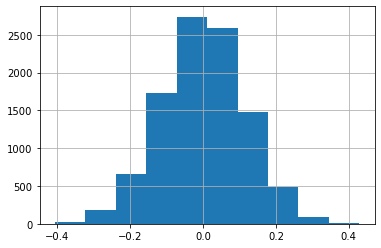

In [26]:
# simulate g(X) for "CCUS-enabled producer serving a large industrial cluster: Industry-specific mix"
g_subarchetype4_simulations = (
 df_weights["subarchetype4"][0]*df_simulations['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype4"][1]*df_simulations['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype4"][2]*df_simulations['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype4"][3]*df_simulations['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype4"][4]*df_simulations['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype4"][5]*df_simulations['x6'] #weight of x6 * observations of x6
)

g_subarchetype4_simulations

g_subarchetype4_simulations.hist()

#### Compute the left-sided probability of g distribution, for subarchetype 4

<AxesSubplot:ylabel='Probability'>

Text(0.5, 1.0, 'Subarchetype 4 Simulated Distribution - Normal x_i assumption')

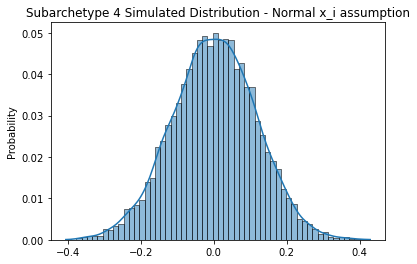

In [27]:
# let's create the empirical distribution of g archetype 4
sns.histplot(data=g_subarchetype4_simulations, kde=True, stat='probability')
plt.title("Subarchetype 4 Simulated Distribution - Normal x_i assumption")


plt.savefig('g_subarchetype4_distribution-NORMAL_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.405756,0.000000
1,-0.401563,0.000019
2,-0.397370,0.000043
3,-0.393177,0.000072
4,-0.388984,0.000110
...,...,...
195,0.411852,0.999769
196,0.416045,0.999799
197,0.420238,0.999825
198,0.424431,0.999847


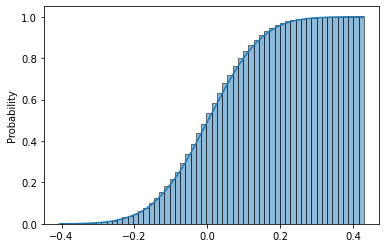

In [28]:
# get data from CDF
df_g_subarchetype4_probabilities = pd.DataFrame(
    np.transpose(
        sns.histplot(data=g_subarchetype4_simulations, kde=True, stat='probability', cumulative = True)
             .get_lines()[0].get_data()
            )
)

df_g_subarchetype4_probabilities.rename(columns={0:'Left-Sided Demand Deviation',1:'Probability'}, inplace=True)
df_g_subarchetype4_probabilities

# note that there is 0 probability of -0.5 demand deviation

In [29]:
# store results for subarchetype 4

df_subarchetype_results.at[3,'Below Rate of Return']=df_g_subarchetype4_probabilities.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g4,df_g_subarchetype4_probabilities,'Left-Sided Demand Deviation')[1]
][1]

# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_results.at[3,'Negative Operating Profit']=df_g_subarchetype4_probabilities.loc[
    find_neighbours(
        NEG_OPER_PROFIT,df_g_subarchetype4_probabilities,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_results.at[3,'Negative Operating Profit']=0
    
    
try:
    df_subarchetype_results.at[3,'40%']=df_g_subarchetype4_probabilities.loc[
    find_neighbours(
        FOURTY_PERCENT_g4,df_g_subarchetype4_probabilities,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_results.at[3,'40%']=0    
    
    
df_subarchetype_results

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.002402,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,0.001834,0.0,0.0
2,3: CCUS-enabled producer serving a large indus...,0.028305,0.0,0.0
3,4: CCUS-enabled producer serving a large indus...,0.000767,0.0,0.0
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 5) Simulate the fifth subarchetype: "CCUS-enabled producer serving a large industrial cluster: Many off-takers"

0       0.120592
1      -0.033265
2       0.126241
3      -0.013725
4      -0.107706
          ...   
9995    0.167302
9996   -0.152379
9997   -0.061784
9998    0.072868
9999   -0.064043
Length: 10000, dtype: float64

<AxesSubplot:>

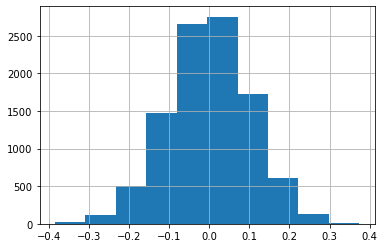

In [30]:
# simulate g(X) for "CCUS-enabled producer serving a large industrial cluster: Many off-takers"
g_subarchetype5_simulations = (
 df_weights["subarchetype5"][0]*df_simulations['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype5"][1]*df_simulations['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype5"][2]*df_simulations['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype5"][3]*df_simulations['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype5"][4]*df_simulations['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype5"][5]*df_simulations['x6'] #weight of x6 * observations of x6
)

g_subarchetype5_simulations

g_subarchetype5_simulations.hist()

#### Compute the left-sided probability of g distribution, for subarchetype 5

<AxesSubplot:ylabel='Probability'>

Text(0.5, 1.0, 'Subarchetype 5 Simulated Distribution - Normal x_i assumption')

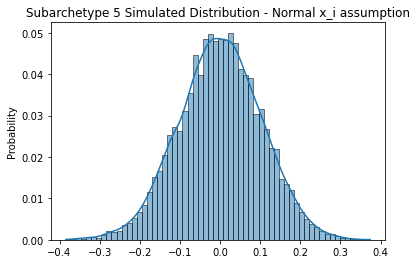

In [31]:
# let's create the empirical distribution of g archetype 5
sns.histplot(data=g_subarchetype5_simulations, kde=True, stat='probability')
plt.title("Subarchetype 5 Simulated Distribution - Normal x_i assumption")


plt.savefig('g_subarchetype5_distribution-NORMAL_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.384452,0.000000
1,-0.380640,0.000026
2,-0.376827,0.000058
3,-0.373015,0.000097
4,-0.369203,0.000144
...,...,...
195,0.358939,0.999801
196,0.362751,0.999820
197,0.366563,0.999837
198,0.370375,0.999852


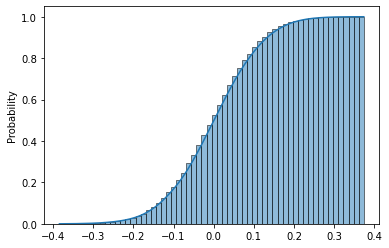

In [32]:
# get data from CDF
df_g_subarchetype5_probabilities = pd.DataFrame(
    np.transpose(
        sns.histplot(data=g_subarchetype5_simulations, kde=True, stat='probability', cumulative = True)
             .get_lines()[0].get_data()
            )
)

df_g_subarchetype5_probabilities.rename(columns={0:'Left-Sided Demand Deviation',1:'Probability'}, inplace=True)
df_g_subarchetype5_probabilities

# note that there is 0 probability of -0.5 demand deviation

In [33]:
# store results for subarchetype 5

df_subarchetype_results.at[4,'Below Rate of Return']=df_g_subarchetype5_probabilities.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g5,df_g_subarchetype5_probabilities,'Left-Sided Demand Deviation')[1]
][1]

# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_results.at[4,'Negative Operating Profit']=df_g_subarchetype5_probabilities.loc[
    find_neighbours(
        NEG_OPER_PROFIT,df_g_subarchetype5_probabilities,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_results.at[4,'Negative Operating Profit']=0
    
    
    
try:
    df_subarchetype_results.at[4,'40%']=df_g_subarchetype5_probabilities.loc[
    find_neighbours(
        FOURTY_PERCENT_g5,df_g_subarchetype5_probabilities,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_results.at[4,'40%']=0    
    
    
df_subarchetype_results

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.002402,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,0.001834,0.0,0.0
2,3: CCUS-enabled producer serving a large indus...,0.028305,0.0,0.0
3,4: CCUS-enabled producer serving a large indus...,0.000767,0.0,0.0
4,5: CCUS-enabled producer serving a large indus...,0.000267,0.0,0.0
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 6) Simulate the sixth subarchetype: "Small co-developed renewable electrolytic sites for assorted uses"

0       0.050899
1       0.028454
2       0.119002
3      -0.102479
4       0.009583
          ...   
9995    0.106639
9996   -0.209212
9997   -0.056896
9998    0.019035
9999   -0.124968
Length: 10000, dtype: float64

<AxesSubplot:>

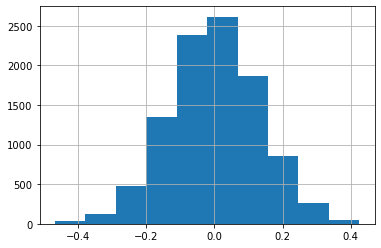

In [34]:
# simulate g(X) for "Small co-developed renewable electrolytic sites for assorted uses"
g_subarchetype6_simulations = (
 df_weights["subarchetype6"][0]*df_simulations['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype6"][1]*df_simulations['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype6"][2]*df_simulations['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype6"][3]*df_simulations['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype6"][4]*df_simulations['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype6"][5]*df_simulations['x6'] #weight of x6 * observations of x6
)

g_subarchetype6_simulations

g_subarchetype6_simulations.hist()

#### Compute the left-sided probability of g distribution, for subarchetype 6

<AxesSubplot:ylabel='Probability'>

Text(0.5, 1.0, 'Subarchetype 6 Simulated Distribution - Normal x_i assumption')

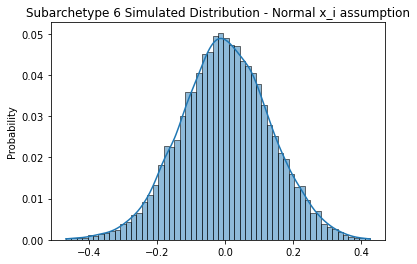

In [35]:
# let's create the empirical distribution of g archetype 6
sns.histplot(data=g_subarchetype6_simulations, kde=True, stat='probability')
plt.title("Subarchetype 6 Simulated Distribution - Normal x_i assumption")


plt.savefig('g_subarchetype6_distribution-NORMAL_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.468735,0.000000
1,-0.464241,0.000065
2,-0.459747,0.000140
3,-0.455253,0.000225
4,-0.450759,0.000318
...,...,...
195,0.407603,0.999258
196,0.412097,0.999352
197,0.416591,0.999435
198,0.421085,0.999506


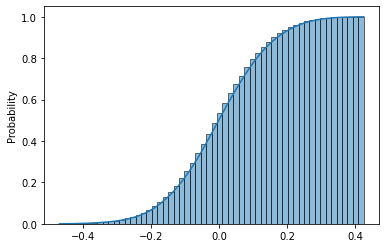

In [36]:
# get data from CDF
df_g_subarchetype6_probabilities = pd.DataFrame(
    np.transpose(
        sns.histplot(data=g_subarchetype6_simulations, kde=True, stat='probability', cumulative = True)
             .get_lines()[0].get_data()
            )
)

df_g_subarchetype6_probabilities.rename(columns={0:'Left-Sided Demand Deviation',1:'Probability'}, inplace=True)
df_g_subarchetype6_probabilities

# note that there is 0 probability of -0.5 demand deviation

In [37]:
# store results for subarchetype 6

df_subarchetype_results.at[5,'Below Rate of Return']=df_g_subarchetype6_probabilities.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g6,df_g_subarchetype6_probabilities,'Left-Sided Demand Deviation')[1]
][1]

# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_results.at[5,'Negative Operating Profit']=df_g_subarchetype6_probabilities.loc[
    find_neighbours(
        NEG_OPER_PROFIT,df_g_subarchetype6_probabilities,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_results.at[5,'Negative Operating Profit']=0
    
    
try:
    df_subarchetype_results.at[5,'40%']=df_g_subarchetype6_probabilities.loc[
    find_neighbours(
        FOURTY_PERCENT_g6,df_g_subarchetype6_probabilities,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_results.at[5,'40%']=0    
    
    
df_subarchetype_results

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.002402,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,0.001834,0.0,0.0
2,3: CCUS-enabled producer serving a large indus...,0.028305,0.0,0.0
3,4: CCUS-enabled producer serving a large indus...,0.000767,0.0,0.0
4,5: CCUS-enabled producer serving a large indus...,0.000267,0.0,0.0
5,6: Small co-developed renewable electrolytic s...,0.009830,0.0,0.0


### STORE RESULTS

In [38]:
# save to csv

df_subarchetype_results.to_csv('subarchetype_results-normal_underlying.csv')

# ---------------------------------------------------------------------------------------------------------------

# ---- In the second step, we want to generate simulations from the 6 underlying RV, $ x_i $,  for i = 1,...,6, where simulations will come from the bootstrap, which does not place distributional assumptions on the underyling data generating process ----

In [39]:
from sklearn.utils import resample

In [40]:
# import raw data to bootstrap with
df_bootstrap_input = pd.read_excel("Variance Matrices.xlsx", sheet_name = "bootstrap_input")
df_bootstrap_input

,x1,x2,x3,x4,x5,x6
0,0.183895,0.138603,0.095182,0.488166,NaN,0.050584
1,-0.229089,0.127632,0.007235,0.089415,NaN,-0.042802
2,-0.476099,0.160255,0.121134,0.038808,NaN,-0.019455
3,0.228002,-0.033193,0.034436,0.090117,NaN,0.091440
4,0.154953,0.215622,0.145104,0.084269,NaN,0.295720
5,-0.069609,-0.084052,0.044111,0.016009,NaN,0.225681
6,-0.015712,0.020585,0.139906,0.138137,NaN,0.295720
7,-0.417742,-0.199899,-0.015584,-0.165202,NaN,0.284047
8,0.151618,0.264910,0.094683,-0.140043,NaN,0.167315
9,0.075644,0.080213,0.183010,0.130201,NaN,0.097276


12    0.262845
8     0.151618
9     0.075644
11    0.119254
5    -0.069609
        ...   
6    -0.015712
16    0.106006
2    -0.476099
9     0.075644
8     0.151618
Name: x1, Length: 10000, dtype: float64

<AxesSubplot:xlabel='x1', ylabel='Count'>

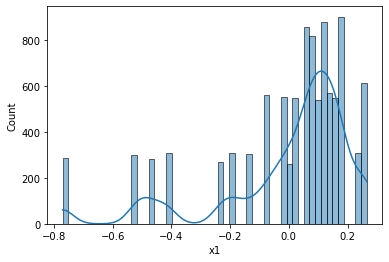

In [41]:
# create bootstrap samples for x1

boot_x1 = resample(df_bootstrap_input['x1'].dropna(), replace=True, n_samples=NUM_SAMPLES, random_state=1)
boot_x1

sns.histplot(boot_x1, kde=True)

12    0.118179
8     0.264910
9     0.080213
11   -0.003879
5    -0.084052
        ...   
21    0.128217
25    0.005539
21    0.128217
4     0.215622
9     0.080213
Name: x2, Length: 10000, dtype: float64

<AxesSubplot:xlabel='x2', ylabel='Count'>

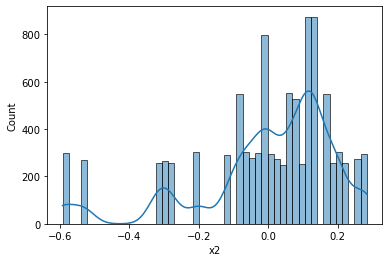

In [42]:
# create bootstrap samples for x2

boot_x2 = resample(df_bootstrap_input['x2'].dropna(), replace=True, n_samples=NUM_SAMPLES, random_state=1)
boot_x2

sns.histplot(boot_x2, kde=True)

12   -0.002881
8     0.094683
9     0.183010
11   -0.145781
5     0.044111
        ...   
21    0.113980
25   -0.088212
21    0.113980
4     0.145104
9     0.183010
Name: x3, Length: 10000, dtype: float64

<AxesSubplot:xlabel='x3', ylabel='Count'>

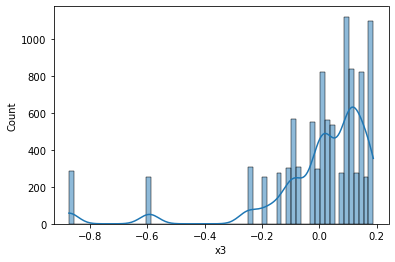

In [43]:
# create bootstrap samples for x3

boot_x3 = resample(df_bootstrap_input['x3'].dropna(), replace=True, n_samples=NUM_SAMPLES, random_state=1)
boot_x3

sns.histplot(boot_x3, kde=True)

12   -0.088924
8    -0.140043
9     0.130201
11   -0.009268
5     0.016009
        ...   
21   -0.040322
25   -0.096912
21   -0.040322
4     0.084269
9     0.130201
Name: x4, Length: 10000, dtype: float64

<AxesSubplot:xlabel='x4', ylabel='Count'>

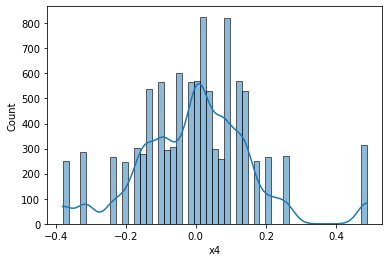

In [44]:
# create bootstrap samples for x4

boot_x4 = resample(df_bootstrap_input['x4'].dropna(), replace=True, n_samples=NUM_SAMPLES, random_state=1)
boot_x4

sns.histplot(boot_x4, kde=True)

18    0.043507
24   -0.215873
25   -0.169373
21    0.103777
22   -0.034982
        ...   
32    0.131411
35    0.031668
21    0.103777
30    0.125160
16   -0.316494
Name: x5, Length: 10000, dtype: float64

<AxesSubplot:xlabel='x5', ylabel='Count'>

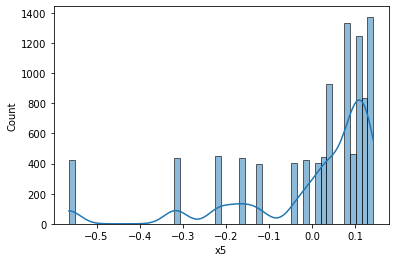

In [45]:
# create bootstrap samples for x5

boot_x5 = resample(df_bootstrap_input['x5'].dropna(), replace=True, n_samples=NUM_SAMPLES, random_state=1)
boot_x5

sns.histplot(boot_x5, kde=True)

12   -0.089494
8     0.167315
9     0.097276
11    0.079767
5     0.225681
        ...   
32    0.015564
21   -0.036965
23   -0.142023
14   -0.147860
26   -0.182879
Name: x6, Length: 10000, dtype: float64

<AxesSubplot:xlabel='x6', ylabel='Count'>

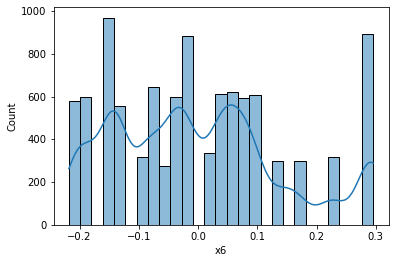

In [46]:
# create bootstrap samples for x6

boot_x6 = resample(df_bootstrap_input['x6'].dropna(), replace=True, n_samples=NUM_SAMPLES, random_state=1)
boot_x6

sns.histplot(boot_x6, kde=True)

In [47]:
bootstrap_array = np.array([
    boot_x1,
    boot_x2,
    boot_x3,
    boot_x4,
    boot_x5,
    boot_x6
])
bootstrap_array

array([[ 0.26284494,  0.15161799,  0.0756438 , ..., -0.47609911,
         0.0756438 ,  0.15161799],
       [ 0.11817854,  0.26491035,  0.08021297, ...,  0.12821678,
         0.2156215 ,  0.08021297],
       [-0.0028811 ,  0.09468266,  0.18301016, ...,  0.11397965,
         0.14510379,  0.18301016],
       [-0.08892426, -0.14004285,  0.13020078, ..., -0.04032152,
         0.08426904,  0.13020078],
       [ 0.0435072 , -0.21587254, -0.16937345, ...,  0.10377732,
         0.12516006, -0.31649383],
       [-0.08949416,  0.16731518,  0.09727626, ..., -0.14202335,
        -0.14785992, -0.18287938]])

In [48]:
# create a dataframe of all x_i bootstrap simulations

df_bootstraps = pd.DataFrame(np.transpose(bootstrap_array))
df_bootstraps.rename(columns = {0:'x1',1:'x2',2:'x3',3:'x4',4:'x5',5:'x6'}, inplace=True)
df_bootstraps

,x1,x2,x3,x4,x5,x6
0,0.262845,0.118179,-0.002881,-0.088924,0.043507,-0.089494
1,0.151618,0.264910,0.094683,-0.140043,-0.215873,0.167315
2,0.075644,0.080213,0.183010,0.130201,-0.169373,0.097276
3,0.119254,-0.003879,-0.145781,-0.009268,0.103777,0.079767
4,-0.069609,-0.084052,0.044111,0.016009,-0.034982,0.225681
...,...,...,...,...,...,...
9995,-0.015712,0.128217,0.113980,-0.040322,0.131411,0.015564
9996,0.106006,0.005539,-0.088212,-0.096912,0.031668,-0.036965
9997,-0.476099,0.128217,0.113980,-0.040322,0.103777,-0.142023
9998,0.075644,0.215622,0.145104,0.084269,0.125160,-0.147860


## So we have created our bootstrap simulations of $ x_i $ for i from 1 to 6. 
## Now we can generate subarchetype simulations: $ g_j(X) $ = weighted sum of $ x_i $, for j subarchetypes (j = 1,...,6)

In [49]:
# create dataframe to store bootstrap_res
df_subarchetype_bootstrap_res = pd.DataFrame(
    {
        "Subarchetype":[
                        "1: Medium grid-sourced electrolytic producer: Transport-focused"
                        ,"2: Medium grid-sourced electrolytic producer: Variety of end-uses"
                        ,"3: CCUS-enabled producer serving a large industrial cluster: Primary off-taker"
                        ,"4: CCUS-enabled producer serving a large industrial cluster: Industry-specific mix"
                        ,"5: CCUS-enabled producer serving a large industrial cluster: Many off-takers"
                        ,"6: Small co-developed renewable electrolytic sites for assorted uses"
                        ],
        "Below Rate of Return":np.nan,
        "Negative Operating Profit":np.nan,
        "40%":np.nan
    }
)

df_subarchetype_bootstrap_res

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,NaN,NaN,NaN
1,2: Medium grid-sourced electrolytic producer: ...,NaN,NaN,NaN
2,3: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 1) Simulate the first subarchetype: "Medium grid-sourced electrolytic producer: Transport-focused"

0       0.016907
1      -0.139235
2      -0.116044
3       0.098975
4       0.017150
          ...   
9995    0.108241
9996    0.017941
9997    0.054617
9998    0.070556
9999   -0.289771
Length: 10000, dtype: float64

<AxesSubplot:ylabel='Probability'>

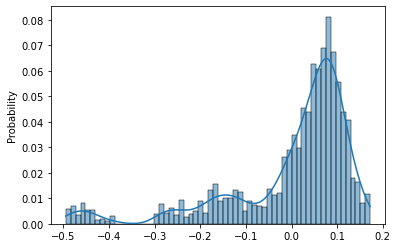

In [50]:

# In[ ]:


# simulate g(X) for "Medium grid-sourced electrolytic producer: Transport-focused"

g_subarchetype1_bootstraps = (
 df_weights["subarchetype1"][0]*df_bootstraps['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype1"][1]*df_bootstraps['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype1"][2]*df_bootstraps['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype1"][3]*df_bootstraps['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype1"][4]*df_bootstraps['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype1"][5]*df_bootstraps['x6'] #weight of x6 * observations of x6
)

g_subarchetype1_bootstraps


# #### Compute the left-sided probability of g distribution, for subarchetype 1

# In[ ]:


# let's create the empirical distribution of g archetype 1 
sns.histplot(data=g_subarchetype1_bootstraps, kde=True, stat='probability')


<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Subarchetype 1 Simulated Distribution - Bootstrapped x_i')

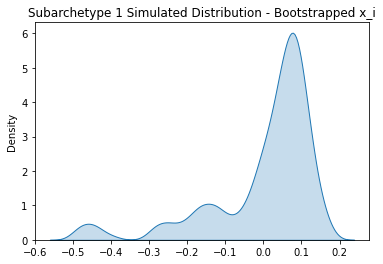

In [51]:
# instead of cutting off the distribution at the lowest empirical value, let's smooth it out

sns.kdeplot(data=g_subarchetype1_bootstraps, shade = True)
plt.title("Subarchetype 1 Simulated Distribution - Bootstrapped x_i")

plt.savefig('g_subarchetype1_distribution-BOOTSTRAP_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.560799,0.000000
1,-0.556783,0.000005
2,-0.552766,0.000014
3,-0.548750,0.000028
4,-0.544734,0.000052
...,...,...
195,0.222336,0.999899
196,0.226352,0.999939
197,0.230368,0.999963
198,0.234384,0.999977


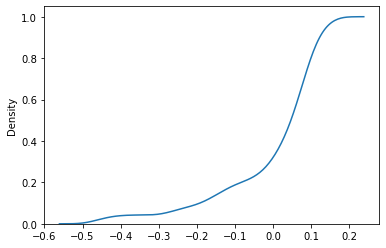

In [52]:
# get data from CDF
kde_g1 = sns.kdeplot(data=g_subarchetype1_bootstraps, cumulative=True)

line = kde_g1.lines[0]
x, y = line.get_data()

df_g_subarchetype1_bootstrap_probs = pd.DataFrame(
    {
        'Left-Sided Demand Deviation':x,
        'Probability':y
    }
)

df_g_subarchetype1_bootstrap_probs

In [53]:
# store bootstrap_res for subarchetype 1

df_subarchetype_bootstrap_res.at[0,'Below Rate of Return']=df_g_subarchetype1_bootstrap_probs.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g1,df_g_subarchetype1_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

try:
    df_subarchetype_bootstrap_res.at[0,'Negative Operating Profit']=df_g_subarchetype1_bootstrap_probs.loc[
        find_neighbours(
            NEG_OPER_PROFIT,df_g_subarchetype1_bootstrap_probs,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_bootstrap_res.at[0,'Negative Operating Profit']=0
    

try:
    df_subarchetype_bootstrap_res.at[0,'40%']=df_g_subarchetype1_bootstrap_probs.loc[
        find_neighbours(
            FOURTY_PERCENT_g1,df_g_subarchetype1_bootstrap_probs,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_bootstrap_res.at[0,'40%']=0
    
df_subarchetype_bootstrap_res

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.017009,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,NaN,NaN,NaN
2,3: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


 ### 2) Simulate the second subarchetype: "Medium grid-sourced electrolytic producer: Variety of end-uses"

0      -0.014498
1      -0.080958
2       0.020281
3       0.010725
4       0.023605
          ...   
9995    0.072535
9996   -0.037311
9997    0.045723
9998    0.092621
9999   -0.066583
Length: 10000, dtype: float64

<AxesSubplot:ylabel='Probability'>

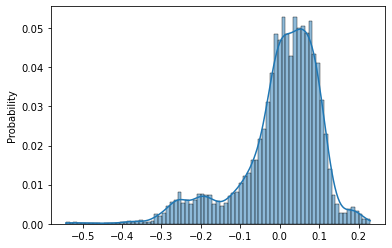

In [54]:

# In[ ]:


# simulate g(X) for "Medium grid-sourced electrolytic producer: Variety of end-uses"
g_subarchetype2_bootstraps = (
 df_weights["subarchetype2"][0]*df_bootstraps['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype2"][1]*df_bootstraps['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype2"][2]*df_bootstraps['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype2"][3]*df_bootstraps['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype2"][4]*df_bootstraps['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype2"][5]*df_bootstraps['x6'] #weight of x6 * observations of x6
)

g_subarchetype2_bootstraps


# #### Compute the left-sided probability of g distribution, for subarchetype 2

# In[ ]:


# let's create the empirical distribution of g archetype 2
sns.histplot(data=g_subarchetype2_bootstraps, kde=True, stat='probability')

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Subarchetype 2 Simulated Distribution - Bootstrapped x_i')

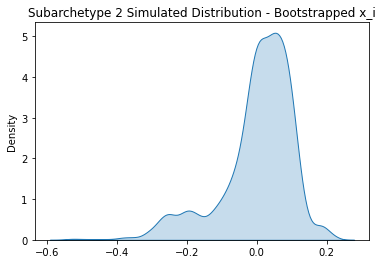

In [55]:
# instead of cutting off the distribution at the lowest empirical value, let's smooth it out

sns.kdeplot(data=g_subarchetype2_bootstraps, shade = True)
plt.title("Subarchetype 2 Simulated Distribution - Bootstrapped x_i")

plt.savefig('g_subarchetype2_distribution-BOOTSTRAP_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.592391,0.000000e+00
1,-0.588012,4.296605e-07
2,-0.583634,1.372113e-06
3,-0.579255,3.310221e-06
4,-0.574876,7.048533e-06
...,...,...
195,0.261484,9.999766e-01
196,0.265863,9.999884e-01
197,0.270242,9.999945e-01
198,0.274621,9.999974e-01


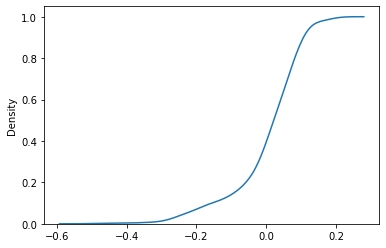

In [56]:
# get data from CDF
kde_g2 = sns.kdeplot(data=g_subarchetype2_bootstraps, cumulative=True)

line = kde_g2.lines[0]
x, y = line.get_data()

df_g_subarchetype2_bootstrap_probs = pd.DataFrame(
    {
        'Left-Sided Demand Deviation':x,
        'Probability':y
    }
)

df_g_subarchetype2_bootstrap_probs

In [57]:
# store bootstrap_res for subarchetype 2

df_subarchetype_bootstrap_res.at[1,'Below Rate of Return']=df_g_subarchetype2_bootstrap_probs.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g2,df_g_subarchetype2_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

try:
    df_subarchetype_bootstrap_res.at[1,'Negative Operating Profit']=df_g_subarchetype2_bootstrap_probs.loc[
        find_neighbours(
            NEG_OPER_PROFIT,df_g_subarchetype2_bootstrap_probs,'Left-Sided Demand Deviation')[1]
    ][1]
    
except ValueError:
    df_subarchetype_bootstrap_res.at[1,'Negative Operating Profit']=0
    
    
    
try:
    df_subarchetype_bootstrap_res.at[1,'40%']=df_g_subarchetype2_bootstrap_probs.loc[
        find_neighbours(
            FOURTY_PERCENT_g2,df_g_subarchetype2_bootstrap_probs,'Left-Sided Demand Deviation')[1]
    ][1]
    
except ValueError:
    df_subarchetype_bootstrap_res.at[1,'40%']=0


df_subarchetype_bootstrap_res


,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.017009,0.0,0.0
1,2: Medium grid-sourced electrolytic producer: ...,0.001902,0.0,0.0
2,3: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 3) Simulate the third subarchetype: "CCUS-enabled producer serving a large industrial cluster: Primary off-taker"

0       0.201095
1       0.116758
2       0.091836
3       0.079899
4      -0.049675
          ...   
9995   -0.005204
9996    0.066293
9997   -0.373513
9998    0.083452
9999    0.152615
Length: 10000, dtype: float64

<AxesSubplot:ylabel='Probability'>

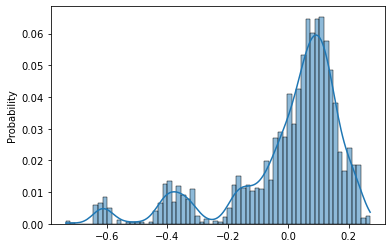

In [58]:


# In[ ]:


# simulate g(X) for "CCUS-enabled producer serving a large industrial cluster: Primary off-taker"
g_subarchetype3_bootstraps = (
 df_weights["subarchetype3"][0]*df_bootstraps['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype3"][1]*df_bootstraps['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype3"][2]*df_bootstraps['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype3"][3]*df_bootstraps['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype3"][4]*df_bootstraps['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype3"][5]*df_bootstraps['x6'] #weight of x6 * observations of x6
)

g_subarchetype3_bootstraps

# #### Compute the left-sided probability of g distribution, for subarchetype 3

# In[ ]:


# let's create the empirical distribution of g archetype 3
sns.histplot(data=g_subarchetype3_bootstraps, kde=True, stat='probability')

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Subarchetype 3 Simulated Distribution - Bootstrapped x_i')

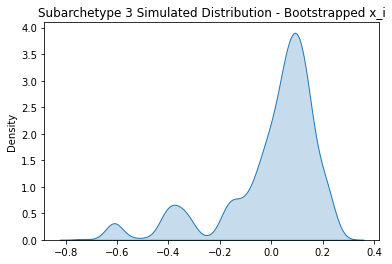

In [59]:
# instead of cutting off the distribution at the lowest empirical value, let's smooth it out

sns.kdeplot(data=g_subarchetype3_bootstraps, shade = True)
plt.title("Subarchetype 3 Simulated Distribution - Bootstrapped x_i")

plt.savefig('g_subarchetype3_distribution-BOOTSTRAP_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.824684,0.000000
1,-0.818729,0.000001
2,-0.812775,0.000003
3,-0.806820,0.000006
4,-0.800865,0.000011
...,...,...
195,0.336523,0.999960
196,0.342477,0.999977
197,0.348432,0.999987
198,0.354387,0.999993


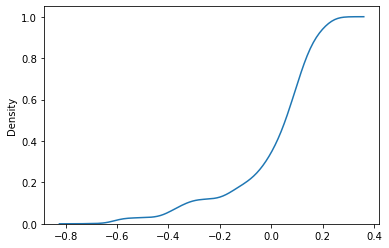

In [60]:
# get data from CDF
kde_g3 = sns.kdeplot(data=g_subarchetype3_bootstraps, cumulative=True)

line = kde_g3.lines[0]
x, y = line.get_data()

df_g_subarchetype3_bootstrap_probs = pd.DataFrame(
    {
        'Left-Sided Demand Deviation':x,
        'Probability':y
    }
)

df_g_subarchetype3_bootstrap_probs

In [61]:

# store bootstrap_res for subarchetype 3

df_subarchetype_bootstrap_res.at[2,'Below Rate of Return']=df_g_subarchetype3_bootstrap_probs.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g3,df_g_subarchetype3_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

try:
    df_subarchetype_bootstrap_res.at[2,'Negative Operating Profit']=df_g_subarchetype3_bootstrap_probs.loc[
        find_neighbours(
            NEG_OPER_PROFIT,df_g_subarchetype3_bootstrap_probs,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_bootstrap_res.at[2,'Negative Operating Profit']=0

    
try:
    df_subarchetype_bootstrap_res.at[2,'40%']=df_g_subarchetype3_bootstrap_probs.loc[
        find_neighbours(
            FOURTY_PERCENT_g3,df_g_subarchetype3_bootstrap_probs,'Left-Sided Demand Deviation')[1]
    ][1]
except ValueError:
    df_subarchetype_bootstrap_res.at[2,'40%']=0    
    
    
df_subarchetype_bootstrap_res

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.017009,0.0,0.000000
1,2: Medium grid-sourced electrolytic producer: ...,0.001902,0.0,0.000000
2,3: CCUS-enabled producer serving a large indus...,0.081694,0.0,0.000102
3,4: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 4) Simulate the fourth subarchetype: "CCUS-enabled producer serving a large industrial cluster: Industry-specific mix"

0       0.072305
1       0.092792
2       0.117267
3      -0.009918
4      -0.023385
          ...   
9995    0.046541
9996   -0.018395
9997   -0.068556
9998    0.130160
9999    0.136260
Length: 10000, dtype: float64

<AxesSubplot:ylabel='Probability'>

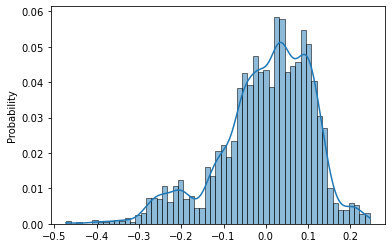

In [62]:


# simulate g(X) for "CCUS-enabled producer serving a large industrial cluster: Industry-specific mix"
g_subarchetype4_bootstraps = (
 df_weights["subarchetype4"][0]*df_bootstraps['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype4"][1]*df_bootstraps['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype4"][2]*df_bootstraps['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype4"][3]*df_bootstraps['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype4"][4]*df_bootstraps['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype4"][5]*df_bootstraps['x6'] #weight of x6 * observations of x6
)

g_subarchetype4_bootstraps


# #### Compute the left-sided probability of g distribution, for subarchetype 4

# In[ ]:


# let's create the empirical distribution of g archetype 4
sns.histplot(data=g_subarchetype4_bootstraps, kde=True, stat='probability')

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Subarchetype 4 Simulated Distribution - Bootstrapped x_i')

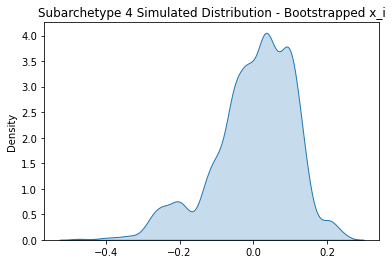

In [63]:
# instead of cutting off the distribution at the lowest empirical value, let's smooth it out

sns.kdeplot(data=g_subarchetype4_bootstraps, shade = True)
plt.title("Subarchetype 4 Simulated Distribution - Bootstrapped x_i")

plt.savefig('g_subarchetype4_distribution-BOOTSTRAP_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.525285,0.000000
1,-0.521143,0.000001
2,-0.517001,0.000004
3,-0.512858,0.000008
4,-0.508716,0.000015
...,...,...
195,0.282489,0.999947
196,0.286632,0.999971
197,0.290774,0.999985
198,0.294916,0.999992


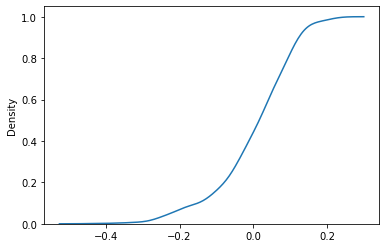

In [64]:
# get data from CDF
kde_g4 = sns.kdeplot(data=g_subarchetype4_bootstraps, cumulative=True)

line = kde_g4.lines[0]
x, y = line.get_data()

df_g_subarchetype4_bootstrap_probs = pd.DataFrame(
    {
        'Left-Sided Demand Deviation':x,
        'Probability':y
    }
)

df_g_subarchetype4_bootstrap_probs

In [65]:

# store bootstrap_res for subarchetype 4

df_subarchetype_bootstrap_res.at[3,'Below Rate of Return']=df_g_subarchetype4_bootstrap_probs.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g4,df_g_subarchetype4_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_bootstrap_res.at[3,'Negative Operating Profit']=df_g_subarchetype4_bootstrap_probs.loc[
    find_neighbours(
        NEG_OPER_PROFIT,df_g_subarchetype4_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_bootstrap_res.at[3,'Negative Operating Profit']=0
    
    
try:
    df_subarchetype_bootstrap_res.at[3,'40%']=df_g_subarchetype4_bootstrap_probs.loc[
    find_neighbours(
        FOURTY_PERCENT_g4,df_g_subarchetype4_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_bootstrap_res.at[3,'40%']=0    
    
    
df_subarchetype_bootstrap_res

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.017009,0.0,0.000000
1,2: Medium grid-sourced electrolytic producer: ...,0.001902,0.0,0.000000
2,3: CCUS-enabled producer serving a large indus...,0.081694,0.0,0.000102
3,4: CCUS-enabled producer serving a large indus...,0.004065,0.0,0.000000
4,5: CCUS-enabled producer serving a large indus...,NaN,NaN,NaN
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 5) Simulate the fifth subarchetype: "CCUS-enabled producer serving a large industrial cluster: Many off-takers"

0       0.047485
1       0.007645
2       0.029276
3       0.033159
4      -0.001958
          ...   
9995    0.068904
9996   -0.005233
9997   -0.024203
9998    0.100858
9999   -0.031480
Length: 10000, dtype: float64

<AxesSubplot:ylabel='Probability'>

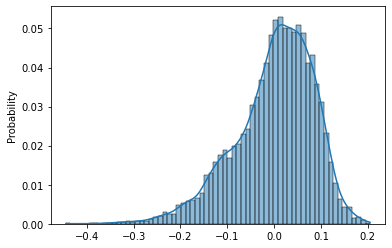

In [66]:

# simulate g(X) for "CCUS-enabled producer serving a large industrial cluster: Many off-takers"
g_subarchetype5_bootstraps = (
 df_weights["subarchetype5"][0]*df_bootstraps['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype5"][1]*df_bootstraps['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype5"][2]*df_bootstraps['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype5"][3]*df_bootstraps['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype5"][4]*df_bootstraps['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype5"][5]*df_bootstraps['x6'] #weight of x6 * observations of x6
)

g_subarchetype5_bootstraps


# #### Compute the left-sided probability of g distribution, for subarchetype 5

# In[ ]:


# let's create the empirical distribution of g archetype 5
sns.histplot(data=g_subarchetype5_bootstraps, kde=True, stat='probability')

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Subarchetype 5 Simulated Distribution - Bootstrapped x_i')

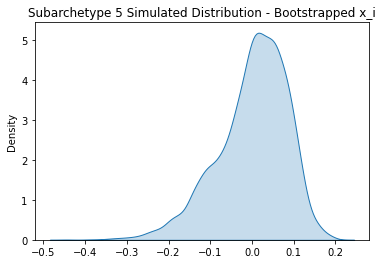

In [67]:
# instead of cutting off the distribution at the lowest empirical value, let's smooth it out

sns.kdeplot(data=g_subarchetype5_bootstraps, shade = True)
plt.title("Subarchetype 5 Simulated Distribution - Bootstrapped x_i")

plt.savefig('g_subarchetype5_distribution-BOOTSTRAP_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.484682,0.000000e+00
1,-0.481015,1.864558e-07
2,-0.477349,5.790395e-07
3,-0.473683,1.345803e-06
4,-0.470017,2.735001e-06
...,...,...
195,0.230211,9.999934e-01
196,0.233877,9.999969e-01
197,0.237543,9.999985e-01
198,0.241209,9.999993e-01


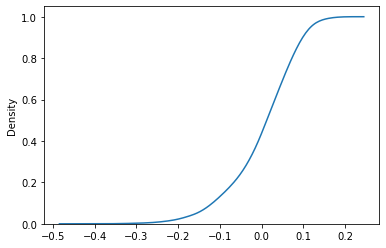

In [68]:
# get data from CDF
kde_g5 = sns.kdeplot(data=g_subarchetype5_bootstraps, cumulative=True)

line = kde_g5.lines[0]
x, y = line.get_data()

df_g_subarchetype5_bootstrap_probs = pd.DataFrame(
    {
        'Left-Sided Demand Deviation':x,
        'Probability':y
    }
)

df_g_subarchetype5_bootstrap_probs

In [69]:

# store bootstrap_res for subarchetype 5

df_subarchetype_bootstrap_res.at[4,'Below Rate of Return']=df_g_subarchetype5_bootstrap_probs.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g5,df_g_subarchetype5_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_bootstrap_res.at[4,'Negative Operating Profit']=df_g_subarchetype5_bootstrap_probs.loc[
    find_neighbours(
        NEG_OPER_PROFIT,df_g_subarchetype5_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_bootstrap_res.at[4,'Negative Operating Profit']=0
    
    
    
# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_bootstrap_res.at[4,'40%']=df_g_subarchetype5_bootstrap_probs.loc[
    find_neighbours(
        FOURTY_PERCENT_g5,df_g_subarchetype5_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_bootstrap_res.at[4,'40%']=0
    
df_subarchetype_bootstrap_res

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.017009,0.0,0.000000
1,2: Medium grid-sourced electrolytic producer: ...,0.001902,0.0,0.000000
2,3: CCUS-enabled producer serving a large indus...,0.081694,0.0,0.000102
3,4: CCUS-enabled producer serving a large indus...,0.004065,0.0,0.000000
4,5: CCUS-enabled producer serving a large indus...,0.000456,0.0,0.000000
5,6: Small co-developed renewable electrolytic s...,NaN,NaN,NaN


### 6) Simulate the sixth subarchetype: "Small co-developed renewable electrolytic sites for assorted uses"

0      -0.027461
1      -0.085431
2       0.009067
3       0.040106
4       0.040357
          ...   
9995    0.054979
9996   -0.032621
9997    0.012408
9998    0.060283
9999   -0.105812
Length: 10000, dtype: float64

<AxesSubplot:ylabel='Probability'>

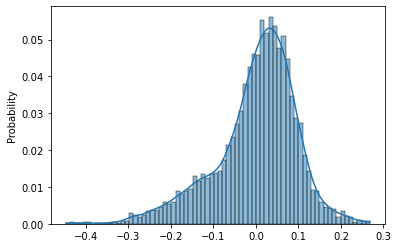

In [70]:

# simulate g(X) for "Small co-developed renewable electrolytic sites for assorted uses"
g_subarchetype6_bootstraps = (
 df_weights["subarchetype6"][0]*df_bootstraps['x1'] #weight of x1 * observations of x1
 +df_weights["subarchetype6"][1]*df_bootstraps['x2'] #weight of x2 * observations of x2
 +df_weights["subarchetype6"][2]*df_bootstraps['x3'] #weight of x3 * observations of x3
 +df_weights["subarchetype6"][3]*df_bootstraps['x4'] #weight of x4 * observations of x4
 +df_weights["subarchetype6"][4]*df_bootstraps['x5'] #weight of x5 * observations of x5
 +df_weights["subarchetype6"][5]*df_bootstraps['x6'] #weight of x6 * observations of x6
)

g_subarchetype6_bootstraps


# #### Compute the left-sided probability of g distribution, for subarchetype 6

# In[ ]:


# let's create the empirical distribution of g archetype 6
sns.histplot(data=g_subarchetype6_bootstraps, kde=True, stat='probability')


<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Subarchetype 6 Simulated Distribution - Bootstrapped x_i')

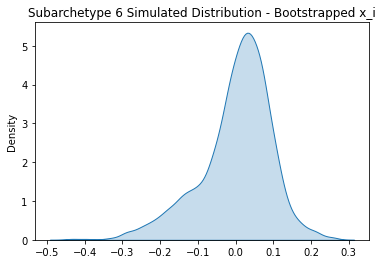

In [71]:
# instead of cutting off the distribution at the lowest empirical value, let's smooth it out

sns.kdeplot(data=g_subarchetype6_bootstraps, shade = True)
plt.title("Subarchetype 6 Simulated Distribution - Bootstrapped x_i")

plt.savefig('g_subarchetype6_distribution-BOOTSTRAP_UNDERLYING.png')

,Left-Sided Demand Deviation,Probability
0,-0.492779,0.000000e+00
1,-0.488724,3.343024e-07
2,-0.484668,1.075830e-06
3,-0.480612,2.619120e-06
4,-0.476556,5.634766e-06
...,...,...
195,0.298115,9.999832e-01
196,0.302170,9.999916e-01
197,0.306226,9.999960e-01
198,0.310282,9.999981e-01


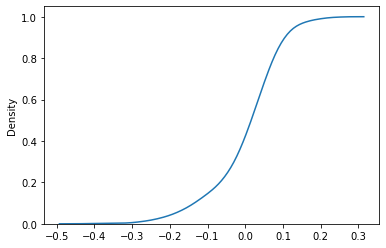

In [72]:
# get data from CDF
kde_g6 = sns.kdeplot(data=g_subarchetype6_bootstraps, cumulative=True)

line = kde_g6.lines[0]
x, y = line.get_data()

df_g_subarchetype6_bootstrap_probs = pd.DataFrame(
    {
        'Left-Sided Demand Deviation':x,
        'Probability':y
    }
)

df_g_subarchetype6_bootstrap_probs

In [73]:

# store bootstrap_res for subarchetype 6

df_subarchetype_bootstrap_res.at[5,'Below Rate of Return']=df_g_subarchetype6_bootstrap_probs.loc[
    find_neighbours(
        BELOW_RATE_OF_RETURN_g6,df_g_subarchetype6_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_bootstrap_res.at[5,'Negative Operating Profit']=df_g_subarchetype6_bootstrap_probs.loc[
    find_neighbours(
        NEG_OPER_PROFIT,df_g_subarchetype6_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_bootstrap_res.at[5,'Negative Operating Profit']=0
    
    
# if 0 probability, there will be an error. If so, then manually set probability to 0
try:
    df_subarchetype_bootstrap_res.at[5,'40%']=df_g_subarchetype6_bootstrap_probs.loc[
    find_neighbours(
        FOURTY_PERCENT_g6,df_g_subarchetype6_bootstrap_probs,'Left-Sided Demand Deviation')[1]
][1]

except ValueError:
    df_subarchetype_bootstrap_res.at[5,'40%']=0
    
df_subarchetype_bootstrap_res

,Subarchetype,Below Rate of Return,Negative Operating Profit,40%
0,1: Medium grid-sourced electrolytic producer: ...,0.017009,0.0,0.000000
1,2: Medium grid-sourced electrolytic producer: ...,0.001902,0.0,0.000000
2,3: CCUS-enabled producer serving a large indus...,0.081694,0.0,0.000102
3,4: CCUS-enabled producer serving a large indus...,0.004065,0.0,0.000000
4,5: CCUS-enabled producer serving a large indus...,0.000456,0.0,0.000000
5,6: Small co-developed renewable electrolytic s...,0.003685,0.0,0.000000


### STORE RESULTS

In [74]:
# save to csv

df_subarchetype_bootstrap_res.to_csv('subarchetype_results-bootstrapped_underlying.csv')